In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [180]:
import pathlib
data_dir = pathlib.Path("../Drug/")

In [181]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

678


In [182]:
batch_size = 32
img_height = 130
img_width = 130

In [183]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 678 files belonging to 5 classes.
Using 543 files for training.


In [184]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 678 files belonging to 5 classes.
Using 135 files for validation.


In [185]:
class_names = train_ds.class_names
print(class_names)

['Atype', 'Btype', 'Ctype', 'Dtype', 'Etype']


In [186]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#將資料預存記憶體
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [187]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [188]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00046700862 1.0


In [189]:
#轉角度增加資料量
data_augmentation = keras.Sequential(
  [
#     layers.experimental.preprocessing.RandomFlip("vertical", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomRotation(0.8),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

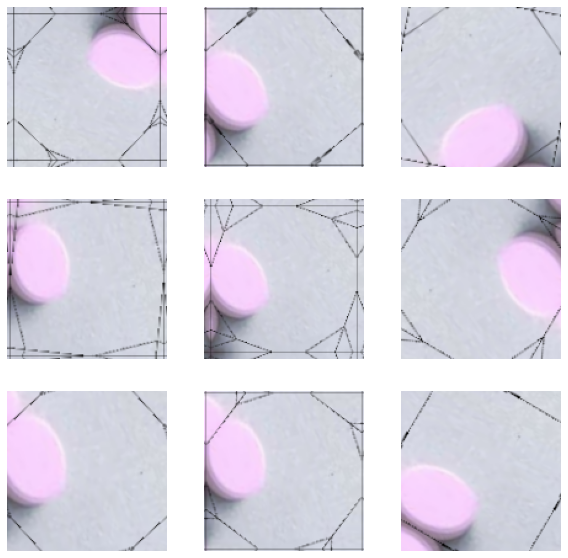

In [190]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [191]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [192]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [193]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
17/17 [==============================] - 5s 287ms/step - loss: 1.4837 - accuracy: 0.4309 - val_loss: 1.2804 - val_accuracy: 0.6296
Epoch 2/30
17/17 [==============================] - 5s 274ms/step - loss: 1.2164 - accuracy: 0.6004 - val_loss: 1.0877 - val_accuracy: 0.6667
Epoch 3/30
17/17 [==============================] - 8s 464ms/step - loss: 1.0700 - accuracy: 0.6298 - val_loss: 1.0717 - val_accuracy: 0.6741
Epoch 4/30
17/17 [==============================] - 8s 447ms/step - loss: 0.9599 - accuracy: 0.6556 - val_loss: 1.0026 - val_accuracy: 0.6741
Epoch 5/30
17/17 [==============================] - 8s 476ms/step - loss: 0.8214 - accuracy: 0.7090 - val_loss: 0.7609 - val_accuracy: 0.7704
Epoch 6/30
17/17 [==============================] - 7s 433ms/step - loss: 0.7562 - accuracy: 0.7643 - val_loss: 0.7640 - val_accuracy: 0.6667
Epoch 7/30
17/17 [==============================] - 8s 479ms/step - loss: 0.6692 - accuracy: 0.7698 - val_loss: 0.5846 - val_accuracy: 0.7926
Epoch 

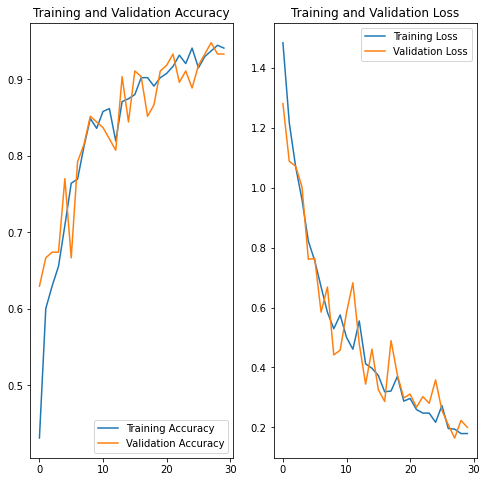

In [194]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [179]:
s = "/Users/WorkToday/Downloads/does/do/Qtern 5mg10mg Film-Coated Tablets8.JPG"
img = cv2.imread(s)
cv2.imwrite(s,img)

img = keras.preprocessing.image.load_img(
    s, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Btype with a 99.08 percent confidence.


In [158]:
s = "../Drug1/circle/CircleWhite99.jpg"
img = cv2.imread(s)
cv2.imwrite(s,img)

img = keras.preprocessing.image.load_img(
    s, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to 白 with a 99.31 percent confidence.


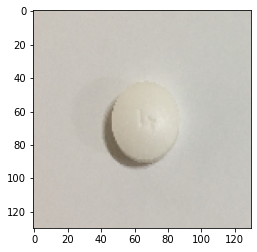

In [154]:
import cv2
img_cv2 = cv2.imread(path)
img_cv2 = PIL.Image.fromarray(cv2.cvtColor(img_cv2,cv2.COLOR_BGR2RGB))
img_cv2 = img_cv2.resize((img_width, img_height),PIL.Image.NEAREST)
plt.imshow(img_keras)